<center>
<h1>Project: K Nearest Neighbors</h1>

<h3>
Introduction to Machine Learning<br>
MSc in Computer Science - Machine Learning and Data Mining<br>
Faculty of Sciences and Techniques<br>
Université Jean Monnet
</h3>

<h2>Team Members:</h2>
<h3>Chelsy Mena & Serhii Vakulenko</h3>
<center>

In [8]:
#%% LIBRARIES USED
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting Seaborn style
sns.set_theme(
    style="darkgrid", 
    context="notebook", 
    rc={
		"axes.facecolor": "#fcfcfc",
        "grid.color": "#605e5e",
        "axes.edgecolor": "#605e5e",
        "text.color": "#4d4d4d",
        "xtick.color": "#605e5e",
        "ytick.color": "#605e5e"
    }
)

palette = sns.color_palette(
    [ "#bb3e03", "#e9d8a6", "#ae2012", "#7f1d1d", "#9b2226", "#ca6702", ]
)
sns.set_palette(palette)

# Setting a default figure size
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
#%% LOAD DATA
data = np.genfromtxt('Files\waveform.data',	delimiter=',')

## 0 Exploratory Data Analysis

We have a dataset with 5000 observations for 21 features and one label. Here we can see our data is fairly balanced as well 

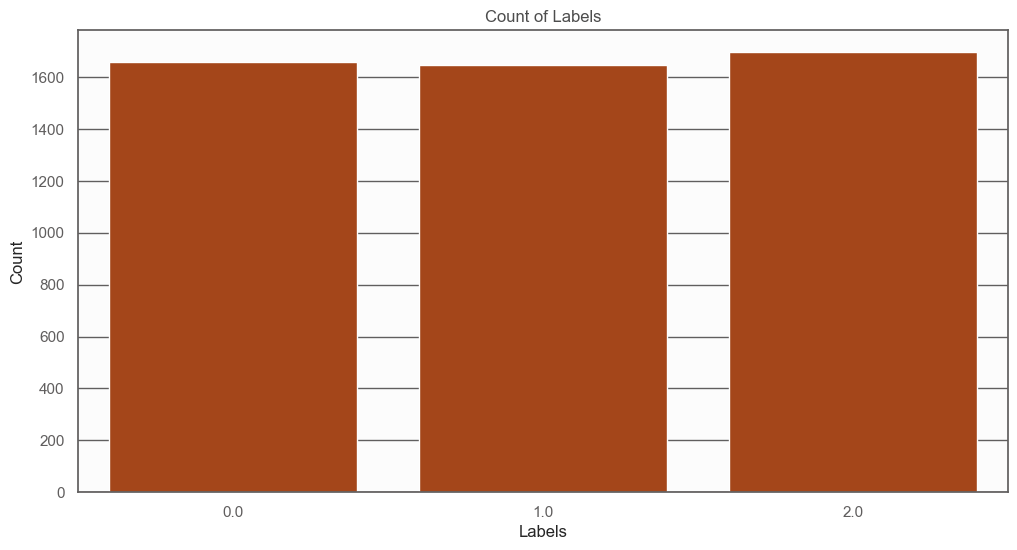

In [9]:
unique, counts = np.unique(data[:,21], return_counts=True)
sns.barplot(x=unique, y=counts)
plt.title("Count of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

Initially, we want to see some pairs of features to understand if the features are easily visualized as is. We select alleatorily some of the features and plot them in 2D spaces below:

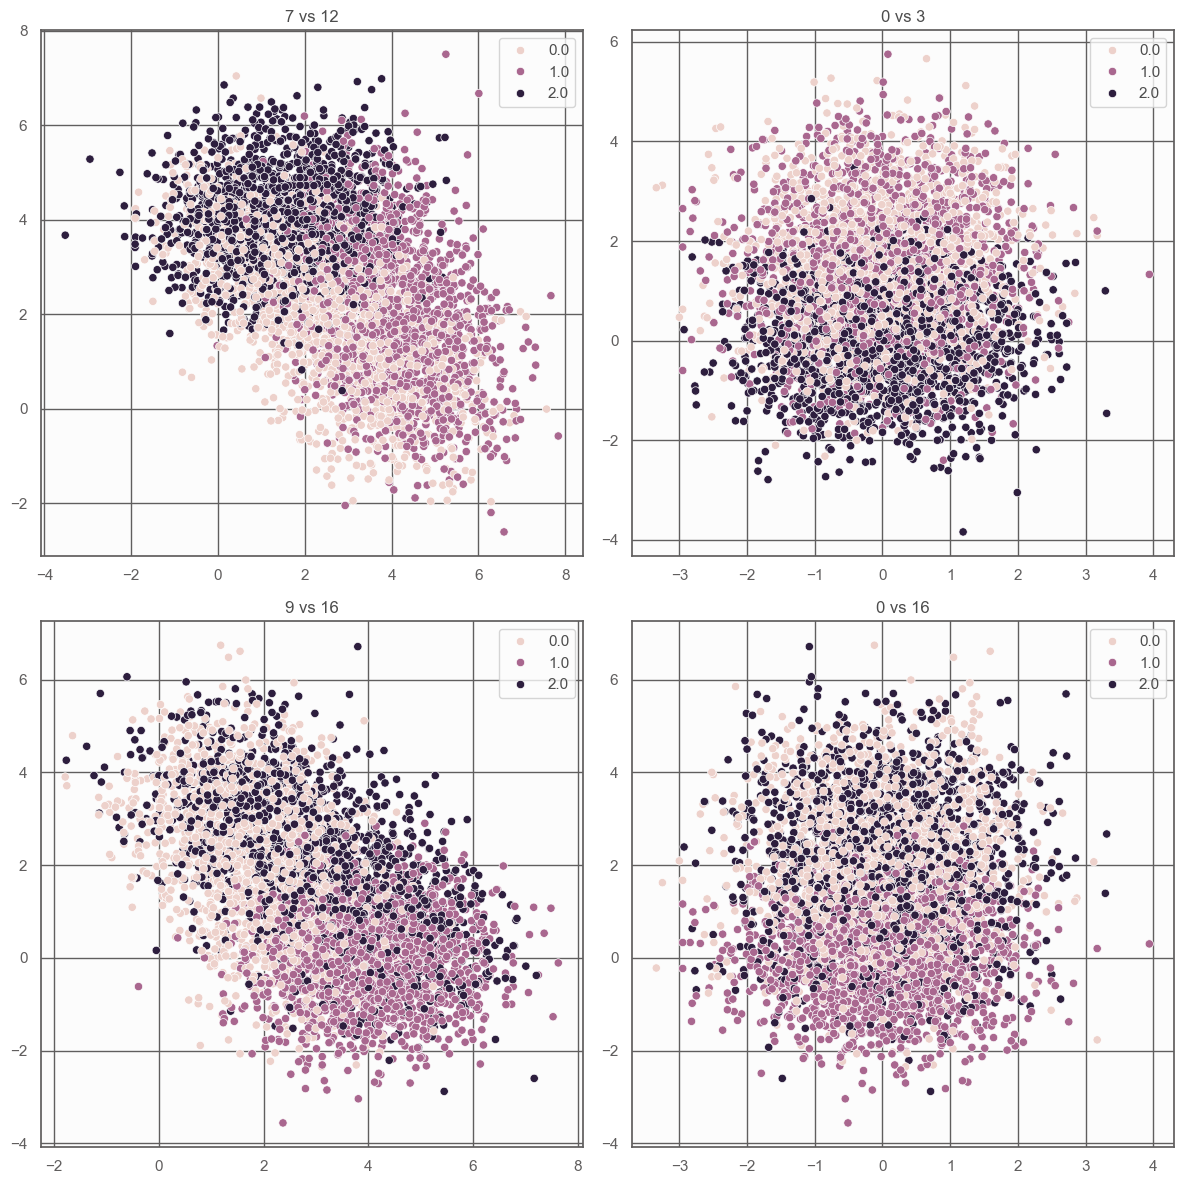

In [4]:
pairs = []
for i in range(4):
    x = np.random.randint(0, data.shape[1]-1)
    y = np.random.randint(0, data.shape[1]-1)
    pairs.append((x, y))

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
for i, (x, y) in enumerate(pairs):
    x_data = data[:, x]
    y_data = data[:, y]
    sns.scatterplot(x=x_data, y=y_data, ax=axes[i], hue=data[:,21])
    axes[i].set_title(f"{x} vs {y}")
plt.tight_layout()
plt.show()

## 1 Train-Test Split and Hyperparameter Tuning

### Function Definitions

In [15]:

def euclidian_distance(point_a, point_b):

	"""
	Calculate the Euclidian Distance for two points
	
	Input: Two points, numpy arrays
	Output: The distance between the two points
	"""

	diffs = 0

	for i in range(point_a.shape[0] - 1):
		diffs += (point_a[i] - point_b[i])**2
	distance = diffs**0.5

	return distance


def distance_matrix(train_data, test_data):

	"""
	Precalculate the distance matrix between two tables
	
	Input: Two numpy arrays with points
	Output: Distance matrix between the two, numpy array
	"""
	
	distance_matrix = []

	for test_point in test_data:
		row = []
		for train_point in train_data:
			distance = euclidian_distance(test_point, train_point)
			row.append(distance)
		distance_matrix.append(row)

	return np.array(distance_matrix)


def knn_predictions(train_data, test_data, k, distance_matrix=None):

	"""Predict the labels for a dataset
	
	Input: 
		- Train dataset, numpy array
		- Test dataset, numpy arrya
		- Number of neighbors to consider
		- Distance matrix if it's precalculated outside
	
	Output: 
		- Array with the predictions
		- Accuracy across the test set
	"""

	predictions = []

	# Pick a point from the test set
	for i in range(test_data.shape[0]):

		#If I precalculated the distances, just have to get the row
		if distance_matrix is not None:
			distances = distance_matrix[i]

		# Else, calculate all distances and store them
		else:
			distances = []

			for train_point in train_data:

				distance = euclidian_distance(test_data[i], train_point)
				distances.append(distance)

		# Pick the indexes of the k nearest neighbors
		if len(distances) > 1:
			k_nearest = np.argpartition(distances, k)[:k]
			k_nearest_labels = train_data[k_nearest][:, 21]
		else: k_nearest_labels = train_data[:, 21]

		# Cast simple majority vote. DOESNT TAKE TIES INTO ACCOUNT
		values, counts = np.unique(k_nearest_labels, return_counts=True)
		label_index = np.where(counts==max(counts))
		majority_label = values[label_index]

		# Store the predictions vs the true stuff
		predictions.append([majority_label[0], test_data[i][21]])

	# Calculate the accuracy
	comparision = list(map(lambda x: 1 if x[0]==x[1] else 0, predictions))
	accuracy = sum(comparision)/len(comparision)

	return predictions, accuracy

## 2 Data Reduction and Speed Up Techniques

### Functions

In [31]:
def bayesian_region(data):

	index_split = np.random.randint(0, data.shape[0])
	S1 = data[: index_split]
	S2 = data[index_split+1:]

	preds, _ = knn_predictions(S2, S1, 1)

	missclassified = []
	for pred in range(len(preds)):
		if preds[pred][0] != preds[pred][1]:
			missclassified.append(pred)
	keep = [x for x in list(range(len(preds))) if x not in missclassified]
	S1 = S1[keep]

	# Now backwards
	preds, _ = knn_predictions(S1, S2, 1)

	missclassified = []
	for pred in range(len(preds)):
		if preds[pred][0] != preds[pred][1]:
			missclassified.append(pred)
	keep = [x for x in list(range(len(preds))) if x not in missclassified]
	S2 = S2[keep]

	kept_data = np.vstack((S1, S2))

	return kept_data

def condensed(data):

	storage = [np.random.randint(0, data.shape[0])]
	dustbin = []

	for point in range(data.shape[0]):

		# Predict the point with the data in storage
		_, acc = knn_predictions(data[storage], data[[point]], 1)

		if acc == 1:
			dustbin.append(point)
		else:
			storage.append(point)
	
	return data[storage]

In [32]:
step_one = bayesian_region(data)

In [33]:
step_two = condensed(step_one)

We can see here how the data's density changes for each step:

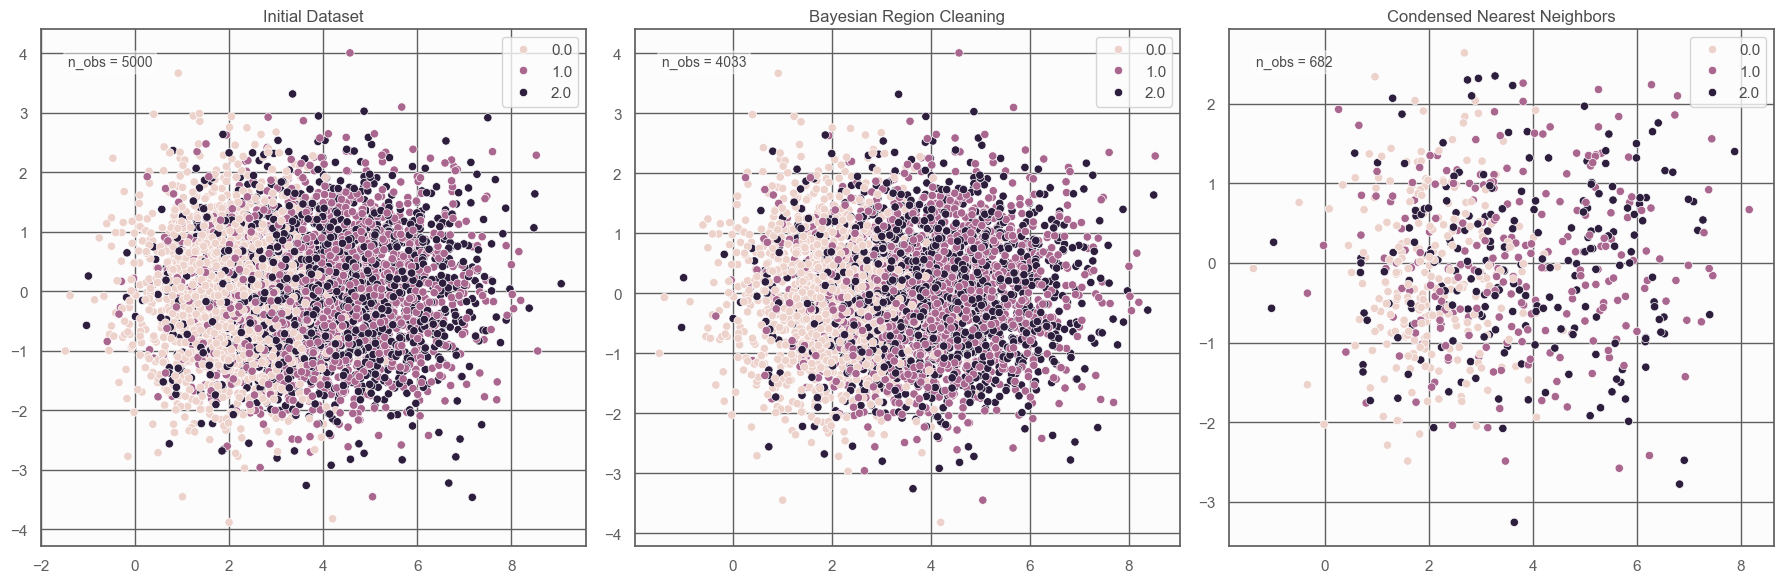

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(x=data[:, 10], y=data[:, 20], hue=data[:, 21], ax=axes[0]).set_title("Initial Dataset")
axes[0].text(
        0.05, 0.95, f"n_obs = {len(data[:, 10])}", 
        transform=axes[0].transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)
    )

sns.scatterplot(x=step_one[:, 10], y=step_one[:, 20], hue=step_one[:, 21], ax=axes[1]).set_title("Bayesian Region Cleaning")
axes[1].text(
        0.05, 0.95, f"n_obs = {len(step_one[:, 10])}", 
        transform=axes[1].transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)
    )

sns.scatterplot(x=step_two[:, 10], y=step_two[:, 20], hue=step_two[:, 21], ax=axes[2]).set_title("Condensed Nearest Neighbors")
axes[2].text(
        0.05, 0.95, f"n_obs = {len(step_two[:, 10])}", 
        transform=axes[2].transAxes, 
        fontsize=10, 
        verticalalignment='top', 
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)
    )

plt.tight_layout()
plt.show()